# Self-instruct Data Generation Using Qwen

You can also check this cookbook in colab [here](https://colab.research.google.com/drive/1tNRrC3u6TjdHz_vG3VicYz6Q7DV_E1cq?usp=sharing)

<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>


The self-instruct pipeline is a technique for automatically generating instructions for large language models (LLMs). Manually creating these datasets can be time-consuming and expensive. The self-instruct pipeline provides a way to automate this process and generate large numbers of instructions quickly and efficiently.

In this notebook, you'll explore:
- **CAMEL-AI**:  A versatile multi-agent framework that facilitates the creation and execution of complex data tasks.
- **Qwen**: A large language model by Alibaba Cloud, used for instruction generation.
- **Self-Instruct Pipeline**: A technique for automating instruction dataset creation.
- **Instruction Filters**: A set of filters that is used to filter a dataset.



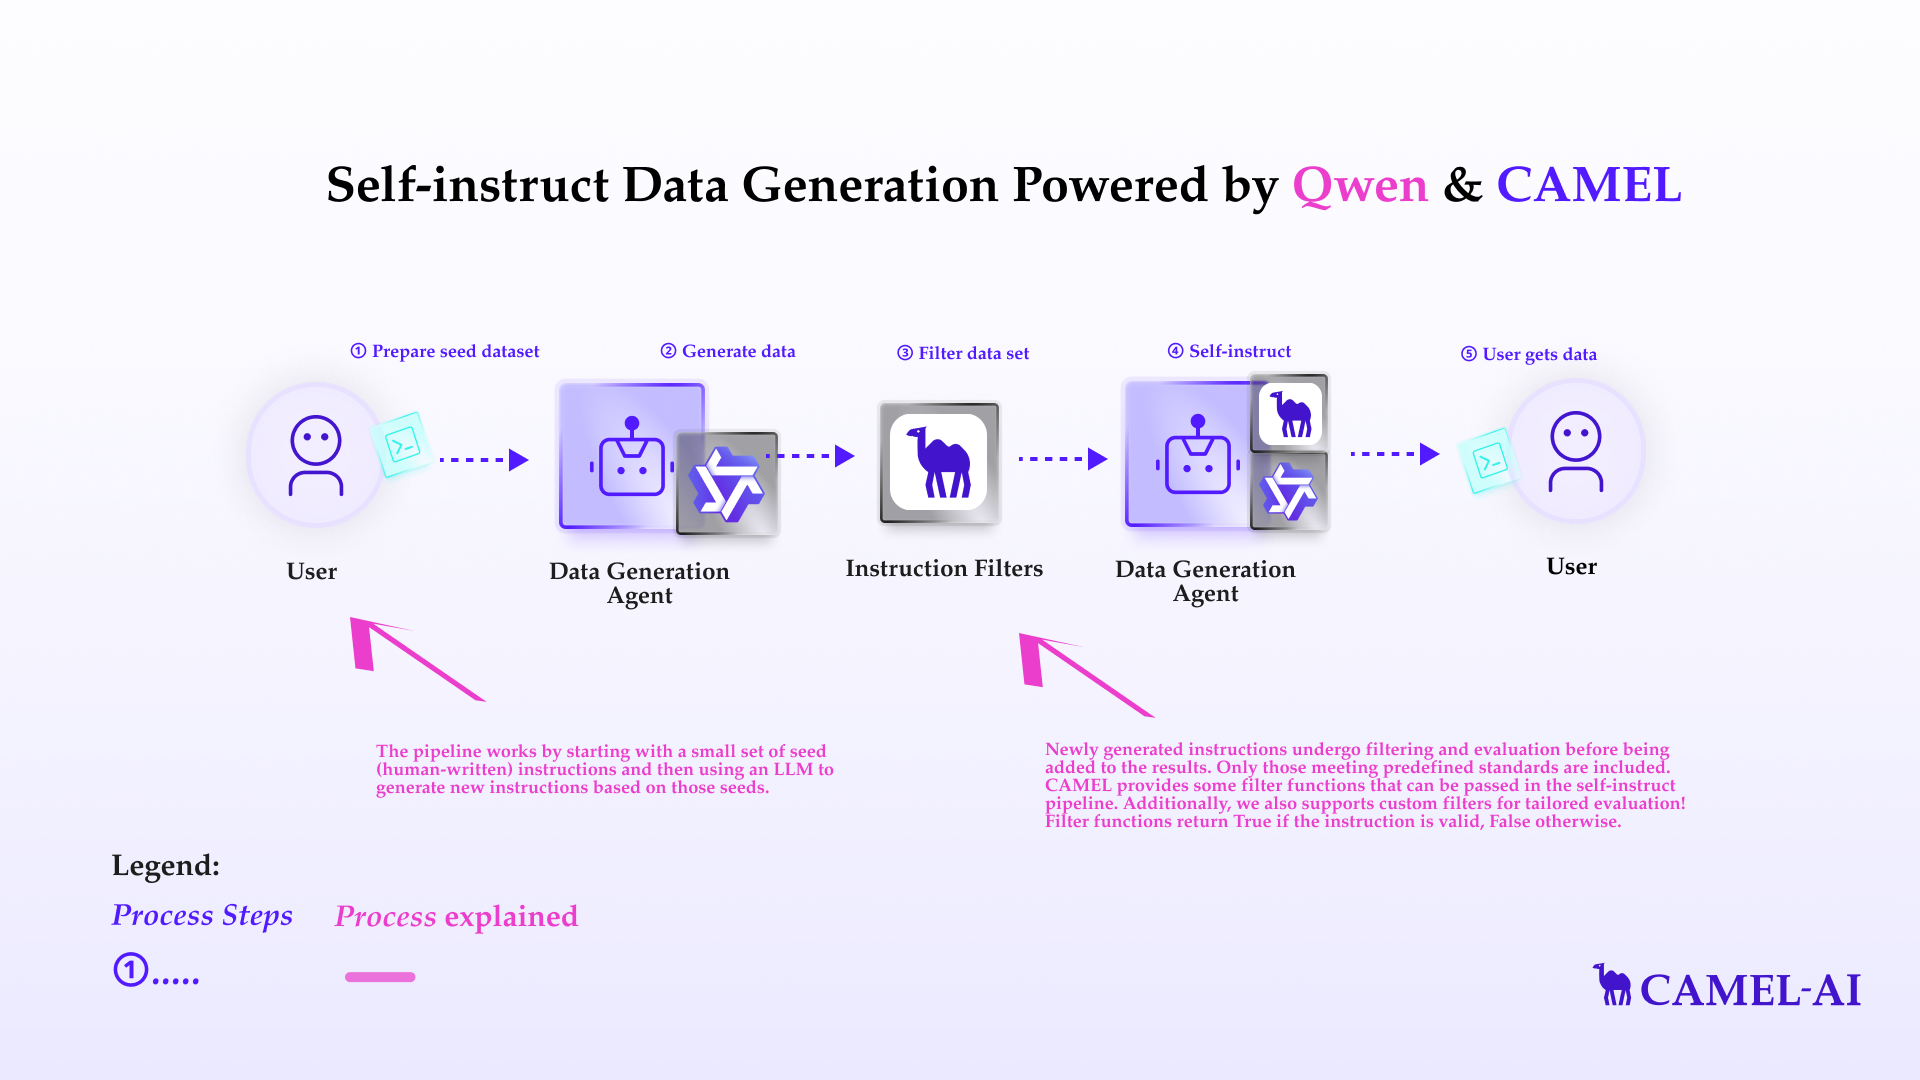


## Installation and Setup
First, install the CAMEL package with all its dependencies

In [ ]:
!pip install "camel-ai[all]==0.2.18"

If you don’t have a Qwen API key, you can obtain one by following these steps:

Visit the Alibaba Cloud Model Studio Console (https://www.alibabacloud.com/en?_p_lc=1) and follow the on-screen instructions to activate the model services.

In the upper-right corner of the console, click on your account name and select API-KEY.

On the API Key management page, click on the Create API Key button to generate a new key.

In [12]:
import os
from getpass import getpass

qwen_api_key = getpass('Enter your Qwen API key: ')
os.environ["QWEN_API_KEY"] = qwen_api_key

Enter your Qwen API key: ··········


Alternatively, if running on Colab, you could save your API keys and tokens as **Colab Secrets**, and use them across notebooks.

To do so, **comment out** the above **manual** API key prompt code block(s), and **uncomment** the following codeblock.

⚠️ Don't forget granting access to the API key you would be using to the current notebook.

In [ ]:
# import os
# from google.colab import userdata

# os.environ["QWEN_API_KEY"] = userdata.get("QWEN_API_KEY")

In [33]:
from camel.configs import QwenConfig
from camel.models import ModelFactory
from camel.types import ModelPlatformType, ModelType
from camel.agents import ChatAgent
from camel.messages import BaseMessage

qwen_model = ModelFactory.create(
    model_platform=ModelPlatformType.QWEN,
    model_type=ModelType.QWEN_TURBO,
    model_config_dict=QwenConfig(temperature=0.2).as_dict(),
)

## Basic Agent Setup

In [34]:
from camel.agents import ChatAgent
from camel.datagen.self_instruct import SelfInstructPipeline

agent = ChatAgent(
    model=qwen_model,
)

## Basic Pipeline Setup


The pipeline works by starting with a small set of seed (human-written) instructions and then using an LLM to generate new instructions based on those seeds.

- The seed instructions are typically stored in a JSON Lines (JSONL) file. Each line in the file represents a single instruction in JSON format.

- Like the seed file, the output is also stored in JSONL format, making it easy to parse and use for further tasks, such as training or fine-tuning language models.


Please replace `seed_path` with the path to your seed file, and replace `data_output_path` with your desired output location.

In [ ]:
import os
import requests

# Create directory for local data
os.makedirs('local_data', exist_ok=True)

# Update the URL to the raw file content
url = "https://raw.githubusercontent.com/camel-ai/camel/master/examples/datagen/self_instruct/seed_tasks.jsonl"

# Fetch the raw file
response = requests.get(url)

with open('local_data/seed_tasks.jsonl', 'wb') as file:
    file.write(response.content)


In [36]:
seed_path = 'local_data/seed_tasks.jsonl'
data_output_path = 'data_output.json'

The cell below shows some example instructions in the seed file. All seed files should follow this format.

In [37]:
with open('local_data/seed_tasks.jsonl', 'r') as file:
        for i, line in enumerate(file):
            print(line.strip())
            if i >= 9:
                break

{"id": "seed_task_0", "name": "breakfast_suggestion", "instruction": "Is there anything I can eat for a breakfast that doesn't include eggs, yet includes protein, and has roughly 700-1000 calories?", "instances": [{"input": "", "output": "Yes, you can have 1 oatmeal banana protein shake and 4 strips of bacon. The oatmeal banana protein shake may contain 1/2 cup oatmeal, 60 grams whey protein powder, 1/2 medium banana, 1tbsp flaxseed oil and 1/2 cup watter, totalling about 550 calories. The 4 strips of bacon contains about 200 calories."}], "is_classification": false}
{"id": "seed_task_1", "name": "antonym_relation", "instruction": "What is the relation between the given pairs?", "instances": [{"input": "Night : Day :: Right : Left", "output": "The relation between the given pairs is that they are opposites."}], "is_classification": false}
{"id": "seed_task_2", "name": "one_sentence_description", "instruction": "Generate a one-sentence description for each of the following people.", "in

The self-instruct pipeline works iteratively. In each round:

1. It selects a certain number of human-written instructions (`num_human_sample`) from the `seed_path`.
2. It selects a certain number of machine-generated instructions (`num_machine_sample`) from previous rounds.
3. It uses these selected instructions to guide the language model in generating new instructions.
4. These new instructions are added to the pool of machine-generated instructions, and the process repeats until the desired number of instructions is generated.

The `human_to_machine_ratio` helps control the balance between human guidance and the model's creativity throughout this process. By adjusting this ratio, you can influence the quality and diversity of the generated instructions.

Feel free to alter `num_human_sample` and `num_machine_sample`, which both will be passed into `human_to_machine_ratio` later

In [38]:
num_human_sample = 6
num_machine_sample = 2

Please replace `target_num_instructions` with the number of machine instructions you want to generate


In [39]:
target_num_instructions = 3

Pass everything to our pipeline.

In [40]:
pipeline = SelfInstructPipeline(
    agent=agent,
    seed=seed_path,
    num_machine_instructions=target_num_instructions,
    data_output_path=data_output_path,
    human_to_machine_ratio=(num_human_sample, num_machine_sample),
)

Try generating it! You will see the generated data file being created at your desired location!

In [41]:
pipeline.generate()

Pretty print the generated data content

In [42]:
import json

with open(data_output_path, 'r') as file:
    data = json.load(file)
    print(json.dumps(data, indent=4))

[
    {
        "id": "machine_task_1",
        "instruction": "Compose a detailed plan for a community initiative aimed at reducing waste in your local area and describe how it could positively impact the environment and community relations.",
        "is_classification": false,
        "instances": [
            {
                "input": "",
                "output": "Plan: Implement a community-wide recycling program that includes regular curbside pickup, educational workshops on waste reduction, and incentives for businesses and residents who participate. Additionally, organize periodic community clean-up events to remove litter and promote community engagement.\n\nImpact: This initiative would significantly reduce the amount of waste sent to landfills, conserve natural resources, and decrease pollution. It would also foster a sense of community pride and cooperation, as residents and businesses work together towards a common goal."
            },
            {
                "in

## Filter functions

Newly generated instructions undergo filtering and evaluation before being added to the results. Only those meeting predefined standards are included. CAMEL provides some filter functions that can be passed in the self-instruct pipeline. Additionally, we also supports custom filters for tailored evaluation! Filter functions return `True` if the instruction is valid, `False` otherwise.

### Length Filter

`LengthFilter` filters out all the instructions which has a length less than `min_len` or greater than `max_len`.

In [43]:
from camel.datagen.self_instruct import LengthFilter

length_filter = LengthFilter(min_len=5, max_len=50)

instructions = [
    "Sort the numbers in ascending order.",
    "Calculate the sum.",
    "Create a report that details the monthly expenses and savings in a spreadsheet."
]

filtered_instructions = [instr for instr in instructions if length_filter.apply(instr)]
print(filtered_instructions)

['Sort the numbers in ascending order.', 'Create a report that details the monthly expenses and savings in a spreadsheet.']


### Keyword Filter

`KeywordFilter` filters instructions that contain specific undesirable keyword.

In [44]:
from camel.datagen.self_instruct import KeywordFilter

keyword_filter = KeywordFilter(keywords=["ban", "prohibit", "forbid"])

instructions = [
    "Ban the use of plastic bags.",
    "Encourage recycling programs.",
    "Prohibit smoking in public areas."
]

filtered_instructions = [instr for instr in instructions if keyword_filter.apply(instr)]
print(filtered_instructions)

['Encourage recycling programs.']


### Punctuation Filter

`PunctuationFilter` filters instructions that begin with a non-alphanumeric character.

In [45]:
from camel.datagen.self_instruct import PunctuationFilter

punctuation_filter = PunctuationFilter()

instructions = [
    "Sort the data by category.",
    "#Analyze the trends over time.",
    "*Create a summary of results."
]

filtered_instructions = [instr for instr in instructions if punctuation_filter.apply(instr)]
print(filtered_instructions)

['Sort the data by category.']


### Non-English Filter

`NonEnglishFilter` filters instructions that do not begin with English letters.

In [46]:
from camel.datagen.self_instruct import NonEnglishFilter

non_english_filter = NonEnglishFilter()

instructions = [
    "Analyze the performance metrics.",
    "计算结果的统计数据.",
    "Test the new algorithm."
]

filtered_instructions = [instr for instr in instructions if non_english_filter.apply(instr)]
print(filtered_instructions)

['Analyze the performance metrics.', 'Test the new algorithm.']


### ROUGE Similarity Filter

`RougeSimilarityFilter` filters instructions that are too similar to existing instructions based on ROUGE scores.

In [47]:
from camel.datagen.self_instruct import RougeSimilarityFilter

existing_instructions = [
    "Summarize the article.",
    "Write a brief overview of the text."
]

similarity_filter = RougeSimilarityFilter(existing_instructions, threshold=0.5)

instructions = [
    "Summarize the content.",
    "Create a summary for the text.",
    "Provide an analysis of the text."
]

filtered_instructions = [instr for instr in instructions if similarity_filter.apply(instr)]
print(filtered_instructions)

['Create a summary for the text.', 'Provide an analysis of the text.']


### Custom Filter Function

Additionally, you could implement your own filter function.

In [48]:
from camel.datagen.self_instruct import FilterFunction

class CustomFilter(FilterFunction):

    def apply(self, instruction: str) -> bool:
        # apply your logic here
        logic = ...
        return logic

## Instruction Filter

`InstructionFilter` manages all filter functions. And we can use a custom InstructionFilter to initialize the pipeline

Start by adding filter functions you want and configure them.

In [49]:
filter_config = {
  "length": {"min_len": 5, "max_len": 100},
  "keyword": {"keywords": ["image", "video"]},
  "non_english": {},
  "rouge_similarity": {
      "existing_instructions": ["Some existing instructions"],
      "threshold": 0.6
  }
}

Then, initialize an `InstructionFilter`

In [50]:
from camel.datagen.self_instruct import InstructionFilter
filters = InstructionFilter(filter_config)

## Pipeline Setup with Custom `InstructionFilter`
CAMEL has some default filter functions inside the pipeline, but you can also choose your own!

In [51]:
pipeline = SelfInstructPipeline(
    agent=agent,
    seed=seed_path,
    num_machine_instructions=target_num_instructions,
    data_output_path=data_output_path,
    human_to_machine_ratio=(num_human_sample, num_machine_sample),
    instruction_filter=filters,    # pass in your InstructionFilter
)

Or if you want to use the default function filters, but different configuration, you can also just pass in the filter configuration

Finally, generate!

In [52]:
pipeline.generate()

Pretty print the generated data content

In [53]:
import json

with open(data_output_path, 'r') as file:
    data = json.load(file)
    print(json.dumps(data, indent=4))

[
    {
        "id": "machine_task_1",
        "instruction": "Write a Python function to determine if a given number is prime.",
        "is_classification": false,
        "instances": [
            {
                "input": "Number: 23",
                "output": "```\ndef is_prime(num):\nif num <= 1:\nreturn False\nfor i in range(2, int(num**0.5) + 1):\nif num % i == 0:\nreturn False\nreturn True\n\nis_prime(23)\n```\nOutput: True"
            },
            {
                "input": "Number: 4",
                "output": "```\ndef is_prime(num):\nif num <= 1:\nreturn False\nfor i in range(2, int(num**0.5) + 1):\nif num % i == 0:\nreturn False\nreturn True\n\nis_prime(4)\n```\nOutput: False"
            }
        ]
    },
    {
        "id": "machine_task_2",
        "instruction": "Generate a correct SQL query to retrieve all records from a specific table where a certain condition is met.",
        "is_classification": false,
        "instances": [
            {
               

That's everything: Got questions about 🐫 CAMEL-AI? Join us on [Discord](https://discord.camel-ai.org)! Whether you want to share feedback, explore the latest in multi-agent systems, get support, or connect with others on exciting projects, we’d love to have you in the community! 🤝

Check out some of our other work:

1. 🐫 Creating Your First CAMEL Agent [free Colab](https://docs.camel-ai.org/cookbooks/create_your_first_agent.html)

2.  Graph RAG Cookbook [free Colab](https://colab.research.google.com/drive/1uZKQSuu0qW6ukkuSv9TukLB9bVaS1H0U?usp=sharing)

3. 🧑‍⚖️ Create A Hackathon Judge Committee with Workforce [free Colab](https://colab.research.google.com/drive/18ajYUMfwDx3WyrjHow3EvUMpKQDcrLtr?usp=sharing)

4. 🔥 3 ways to ingest data from websites with Firecrawl & CAMEL [free Colab](https://colab.research.google.com/drive/1lOmM3VmgR1hLwDKdeLGFve_75RFW0R9I?usp=sharing)

5. 🦥 Agentic SFT Data Generation with CAMEL and Mistral Models, Fine-Tuned with Unsloth [free Colab](https://colab.research.google.com/drive/1lYgArBw7ARVPSpdwgKLYnp_NEXiNDOd-?usp=sharingg)

Thanks from everyone at 🐫 CAMEL-AI


<div class="align-center">
  <a href="https://www.camel-ai.org/"><img src="https://i.postimg.cc/KzQ5rfBC/button.png"width="150"></a>
  <a href="https://discord.camel-ai.org"><img src="https://i.postimg.cc/L4wPdG9N/join-2.png"  width="150"></a></a>
  
⭐ <i>Star us on [*Github*](https://github.com/camel-ai/camel), join our [*Discord*](https://discord.camel-ai.org) or follow our [*X*](https://x.com/camelaiorg)
</div>
